Домашнее задание по теме "Генеративно-состязательные нейронные сети"

ФИО: Червоников Алексей Викторович

### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

Импортируем необходимые модули

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

from tqdm.auto import tqdm
import time

Config:

In [108]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 100
config.print_freq = 100

label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]



Data:

In [9]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 7662934.49it/s] 


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 112366.12it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2105688.13it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10033585.96it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



Dataloader:

In [10]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [11]:
len(dataloader)

3750

In [12]:
for image, cat in dataloader:
    break

In [13]:
image.size()

torch.Size([16, 1, 28, 28])

In [14]:
28*28

784

Объявляем класс Generator и Discriminator

In [15]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [16]:
generator = Generator()
discriminator = Discriminator()

In [17]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [18]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [ ]:
'''Закомментировано чтобы не запускать еще раз'''

# ERRD_x = np.zeros(config.num_epochs)
# ERRD_z = np.zeros(config.num_epochs)
# ERRG = np.zeros(config.num_epochs)
# N = len(dataloader)

# for epoch in range(config.num_epochs):
#     for iteration, (images, cat) in enumerate(dataloader):
#         #######
#         # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
#         #######
#         discriminator.zero_grad()

#         # real
#         label.data.fill_(real_label)
#         input_data = images.view(images.shape[0], -1)
#         output = discriminator(input_data)
#         errD_x = criterion(output, label.view(16, 1))
#         ERRD_x[epoch] += errD_x.item()
#         errD_x.backward()

#         # fake
#         noise.data.normal_(0, 1)
#         fake = generator(noise)
#         label.data.fill_(fake_label)
#         output = discriminator(fake.detach())
#         errD_z = criterion(output, label.view(16, 1))
#         ERRD_z[epoch] += errD_z.item()
#         errD_z.backward()

#         optim_D.step()

#         #######
#         # Generator stage: maximize log(D(G(x))
#         #######
#         generator.zero_grad()
#         label.data.fill_(real_label)
#         output = discriminator(fake)
#         errG = criterion(output, label.view(16, 1))
#         ERRG[epoch] += errG.item()
#         errG.backward()

#         optim_G.step()

#         if (iteration+1) % config.print_freq == 0:
#             print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
#                                                                                             iteration+1,
#                                                                                             errD_x.item(),
#                                                                                             errD_z.item(),
#                                                                                             errG.item()))

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

Получили результаты классического GAN, работающего на основе базовой формулы метода максимизации правдоподобия (Учим генератор отличать true от fake, а дискриминатор обманывать генератор)

#### Задание №1

Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

Немного обновим модели и попробуем задействовать сверточные функции для обучения

Generator:

In [21]:
class GeneratorConv(nn.Module):
    '''Класс модели генератора, который генерирует изображения через операцию ConvTranspose2D()'''
    
    def __init__(self, noise_dim=100, im_chan=1, hidden_dim=64):
        super(GeneratorConv, self).__init__()

        self.noise_dim = 100
        
        # Сеть генератора
        self.from_noise_to_images = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, hidden_dim * 4, kernel_size=3, stride=2, padding=0), 
            nn.BatchNorm2d(hidden_dim * 4), 
            nn.ReLU(inplace=True), 

            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1, padding=0), 
            nn.BatchNorm2d(hidden_dim * 2), 
            nn.ReLU(inplace=True), 

            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=0),  
            nn.BatchNorm2d(hidden_dim),  
            nn.ReLU(inplace=True),  

            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4, stride=2, padding=0),  
            nn.Tanh()  
        )
    
    # forward call
    def forward(self, x):
        return self.from_noise_to_images(x.view(len(x), self.noise_dim, 1, 1))


Проверяем работу ✅

In [22]:
noise_dim = 100  
batch_size = 64

generator = GeneratorConv(noise_dim=noise_dim)

noise = torch.randn(batch_size, noise_dim)

generated_images = generator(noise)
print(f"Выходные размерности изображения генератора: {generated_images.shape}")  

Выходные размерности изображения генератора: torch.Size([64, 1, 28, 28])


Далее необходимо объявить модель дискриминатора

In [23]:
class Critic(nn.Module):
    '''Класс модели критика (дискриминатора)'''

    def __init__(self, in_channels=1):
        super(Critic, self).__init__()

        # Сеть дискриминатора
        self.model_discriminator = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
        )

    # forward call
    def forward(self, x):
        return self.model_discriminator(x)


Проверка ✅

In [24]:
critic_discriminator = Critic()
images = torch.randn(batch_size, 1, 28, 28)  
output = critic_discriminator(images)

print(f"Выходные размерности после forward критика (дискриминатора): {output.shape}")  

Выходные размерности после forward критика (дискриминатора): torch.Size([64, 1])


Далее необходимо реализовать обучение с использованием формулы для WGAN Objective: 



$L(p_{r}, p_{q}) = W(p_{r}, p_{q}) = \max_{\omega \in W} \mathbb{E}_{x \sim p_{r}} [f_{\omega} (x)] - \mathbb{E}_{z \sim p_{r} (z)} [f_{\omega} (g_{\theta} (z))]$,

где критик (дискриминатор) решает задачу максимизации функционала $\mathcal{L}_D$:

$\mathcal{L}_D = \mathbb{E}_{x \sim p_{\text{data}}}  [D(x)] - \mathbb{E}_{z \sim p_{z}} [D(G(z))] \rightarrow max$, 

а генератор минимизирует функционал $\mathcal{L}_G$:

$\mathcal{L}_G = - \mathbb{E}_{z \sim p_{r} (z)} [D(G(z))] \rightarrow min$

В статье приведен алгоритм решения данной задачи

<img src="pictures/wgan_algorithm.png" alt="WGAN algorithm" width="600" height="400">


Необходимо сделать что-то похожее

Напишем функции потерь

Генератор:

In [25]:
def get_gen_loss(crit_fake_pred):
    '''
    Функция потерь для генератора
    
    Параметры:
    -crit_fake_pred: предсказания критика на fake-данных
    
    Возвращает потери генератора
    '''
    gen_loss = -1.0 * torch.mean(crit_fake_pred)
    return gen_loss

Критик (дискриминатор):

In [26]:
def get_crit_loss(crit_fake_pred, crit_real_pred):
    '''
    Функция потерь для критика
    
    Параметры:
    -crit_fake_pred: предсказания критика на fake-данных
    -crit_real_pred: предсказания критика на real-данных
    
    Возвращает потери критика
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) 
    return crit_loss

Дополнительная функция отображения результатов

In [27]:
def generate_and_plot(generator, fixed_noise, epoch):
    '''
    Генерация и отображение картинок от генератора.
    
    Параметры
    -generator: генератор
    -fixed_noise: фиксированный шум
    -epoch: номер эпохи
    '''
    
    # Генерация изображений из шума
    with torch.no_grad():
        generated_images = generator(fixed_noise).cpu().numpy()

    _, axes = plt.subplots(4, 4, figsize=(4, 4))
    axes = axes.flatten()
    
    for i in range(16):
        ax = axes[i]
        ax.imshow(generated_images[i][0], cmap='gray')
        ax.axis('off')
    
    # plt.title(f'Сгенерированные изображения после {epoch} эпохи')
    plt.tight_layout()
    plt.show()


Теперь необходимо объявить функцию обучения

In [28]:
def train_wgan(generator, 
            critic, 
            train_loader, 
            optimizer_generator, 
            optimizer_discriminator, 
            num_epochs=10, 
            clip_value=0.01, 
            n_critic=5, 
            device = 'cpu'):
    '''
    Функция обучения для WGAN
    
    Параметры:
    
    -generator: генератор (модель генератора)
    -critic: критик (дискриминатор)
    -train_loader: тренировочный dataloader
    -optimizer_generator: оптимизатор для генератора
    -optimizer_discriminator: оптимизатор для критика
    -num_epochs: количество эпох для обучения
    -clip_value: значение для ограничения весов (weight clipping)
    -n_critic: количество шагов для критика перед шагом генератора
    -device: устройство
    '''
    
    generator.train()
    critic.train()

    fixed_noise = torch.randn(16, 100, device=device) 
    
    critic_losses = []  # Потери критика
    generator_losses = []  # Потери генератора

    for epoch in tqdm(range(num_epochs)):
        
        start_time = time.time()
        critic_loss_total = 0
        generator_loss_total = 0
        for i, (real_data, _) in enumerate(tqdm(train_loader)):
            
            real_data = real_data.to(device)
            # генерация шума размерности 100
            noise = torch.randn(real_data.size(0), 100, device=device)  
            # n_critic шагов для критика
            for _ in range(n_critic):
                optimizer_discriminator.zero_grad()
                # Генерация фейковых данных
                fake_data = generator(noise)
                
                real_output = critic(real_data)
                fake_output = critic(fake_data.detach())
                # Loss
                critic_loss = get_crit_loss(fake_output, real_output)
                # Backward
                critic_loss.backward()
                optimizer_discriminator.step()
                # Применяем weight clipping
                for param in critic.parameters():
                    param.data.clamp_(-clip_value, clip_value)
                
                critic_loss_total += critic_loss.item()

            # Очередь генератора
            optimizer_generator.zero_grad()
            # Генерация fake-данных
            fake_data = generator(noise)
            # Output критика на fake-данных
            fake_output = critic(fake_data)
            # Loss
            generator_loss = get_gen_loss(fake_output)
            # Обновляем веса генератора
            generator_loss.backward()
            optimizer_generator.step()
            generator_loss_total += generator_loss.item()
        
        critic_losses.append(critic_loss_total / len(train_loader))
        generator_losses.append(generator_loss_total / len(train_loader))

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Critic Loss: {critic_loss_total/len(train_loader):.4f}, "
            f"Generator Loss: {generator_loss_total/len(train_loader):.4f}",
            f"Epoch Time: {epoch_time:.2f}s")

        fake = fixed_noise
        generate_and_plot(generator, fixed_noise, epoch)
    
    return generator_losses, critic_losses



Посмотрим на данные

In [29]:
dataloader = DataLoader(train, batch_size=64, shuffle=True)

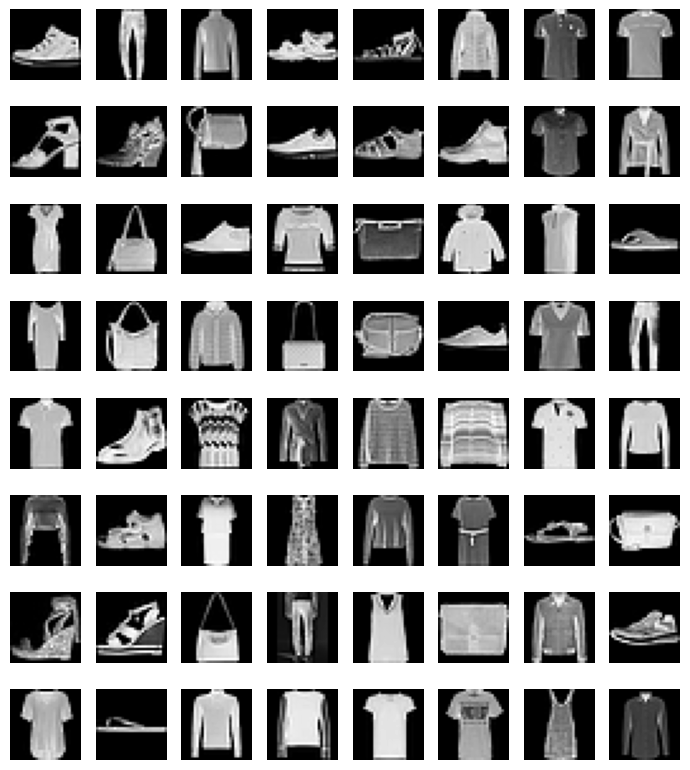

In [30]:
dataiter = iter(dataloader)
images,labels = next(dataiter)

fig, axes = plt.subplots(8, 8, figsize=(7, 8))  
axes = axes.flatten()
for i in range(batch_size):
    ax = axes[i]
    ax.imshow(images[i][0], cmap='gray')
    ax.axis('off')  

plt.tight_layout()
plt.show()

Устройство:

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Устройство: {device}")

Устройство: cuda


Инициализация моделей и оптимизаторов:

In [66]:
generator = GeneratorConv().to(device)
critic = Critic().to(device)

optimizer_generator = optim.RMSprop(generator.parameters(), lr=0.0001)  
optimizer_discriminator = optim.RMSprop(critic.parameters(), lr=0.0001)    

Пробуем обучиться

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Critic Loss: -1.6151, Generator Loss: 0.1261 Epoch Time: 48.63s


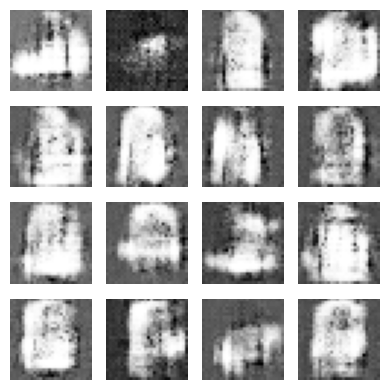

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Critic Loss: -1.1837, Generator Loss: 0.0672 Epoch Time: 48.65s


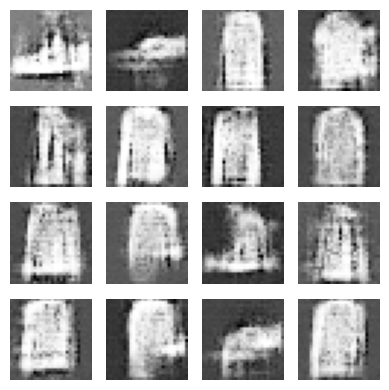

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Critic Loss: -0.9099, Generator Loss: 0.0366 Epoch Time: 48.49s


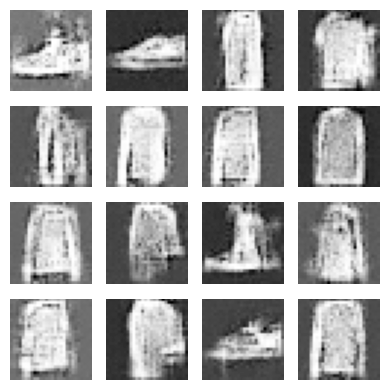

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Critic Loss: -0.7596, Generator Loss: 0.0885 Epoch Time: 48.64s


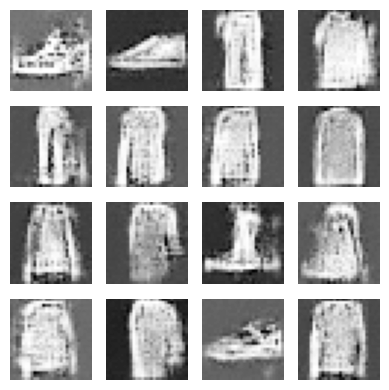

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Critic Loss: -0.6868, Generator Loss: 0.1060 Epoch Time: 48.74s


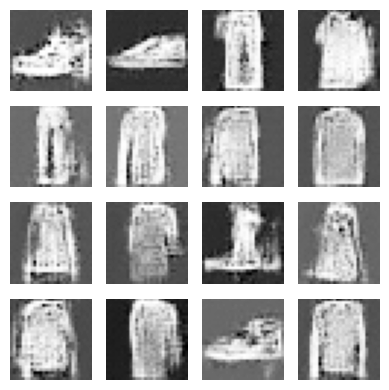

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Critic Loss: -0.6259, Generator Loss: 0.1000 Epoch Time: 48.84s


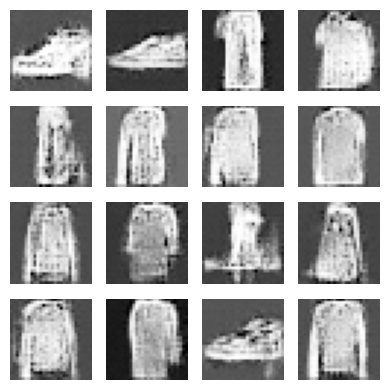

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Critic Loss: -0.5878, Generator Loss: 0.0957 Epoch Time: 48.74s


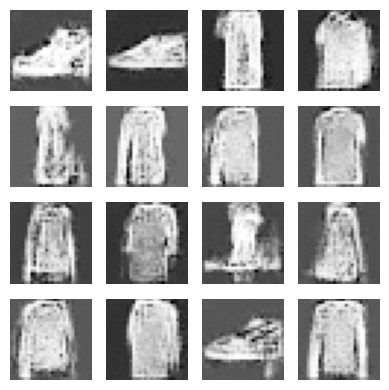

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Critic Loss: -0.5602, Generator Loss: 0.0907 Epoch Time: 48.60s


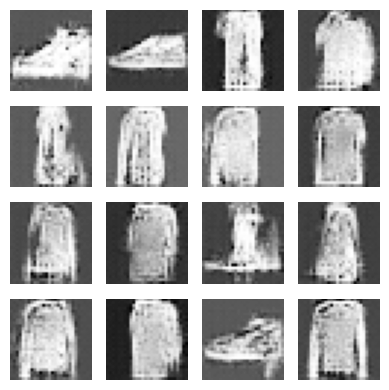

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Critic Loss: -0.5409, Generator Loss: 0.0896 Epoch Time: 48.95s


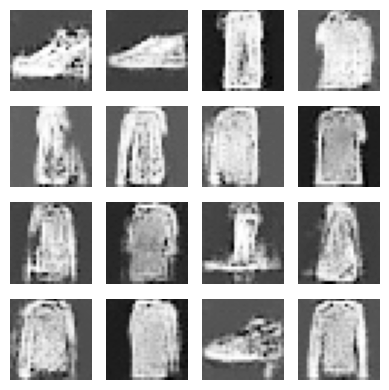

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Critic Loss: -0.5276, Generator Loss: 0.0883 Epoch Time: 48.79s


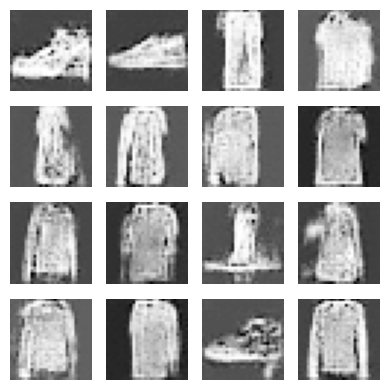

In [67]:
generator_losses, critic_losses = train_wgan(generator, 
           critic, 
           dataloader, 
           optimizer_generator, 
           optimizer_discriminator, 
           num_epochs=10, 
           clip_value=0.01, 
           n_critic=6, 
           device=device)

Потери при обучении

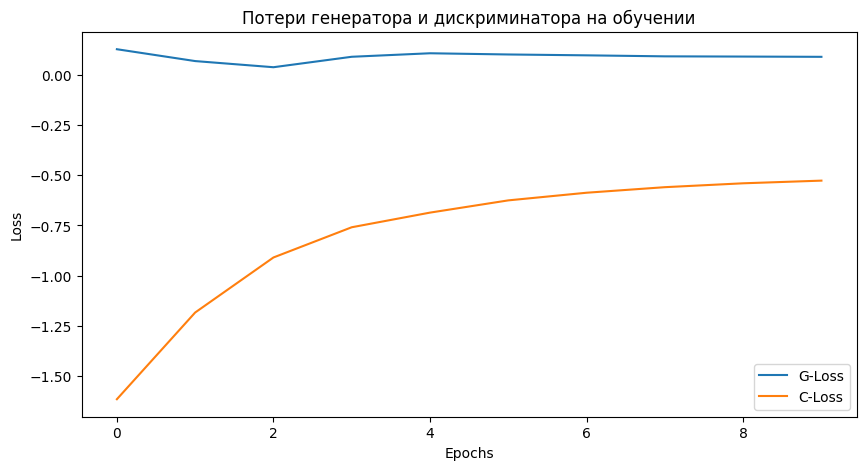

In [68]:
plt.figure(figsize=(10,5))
plt.title("Потери генератора и дискриминатора на обучении")
plt.plot(generator_losses,label="G-Loss")
plt.plot(critic_losses,label="C-Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Если проинициализировать веса

In [51]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [69]:
generator = GeneratorConv().to(device)
critic = Critic().to(device)

generator = generator.apply(weights_init)
critic = critic.apply(weights_init)

optimizer_generator = optim.RMSprop(generator.parameters(), lr=0.0001)  
optimizer_discriminator = optim.RMSprop(critic.parameters(), lr=0.0001)    


Еще раз обучим

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Critic Loss: -1.6970, Generator Loss: 0.1462 Epoch Time: 48.63s


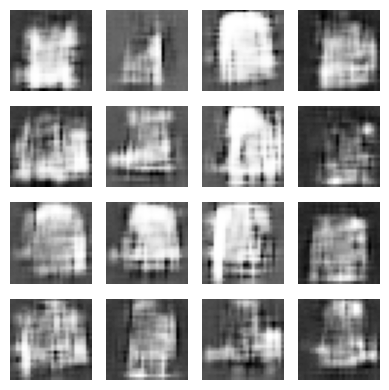

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Critic Loss: -1.0460, Generator Loss: 0.0834 Epoch Time: 48.54s


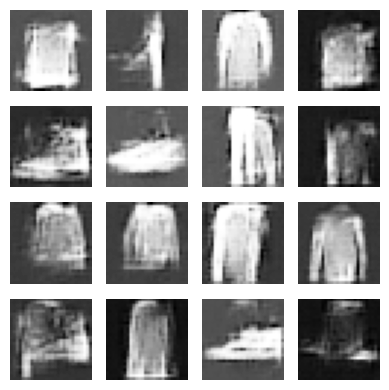

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Critic Loss: -0.7298, Generator Loss: 0.0886 Epoch Time: 48.70s


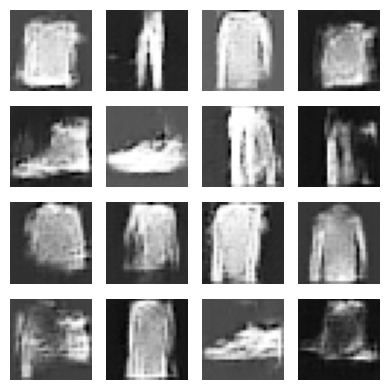

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Critic Loss: -0.6297, Generator Loss: 0.1142 Epoch Time: 48.90s


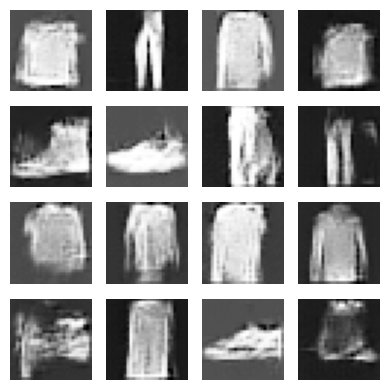

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Critic Loss: -0.5941, Generator Loss: 0.1118 Epoch Time: 49.16s


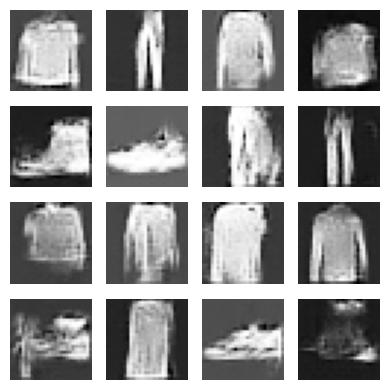

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Critic Loss: -0.5593, Generator Loss: 0.1043 Epoch Time: 48.74s


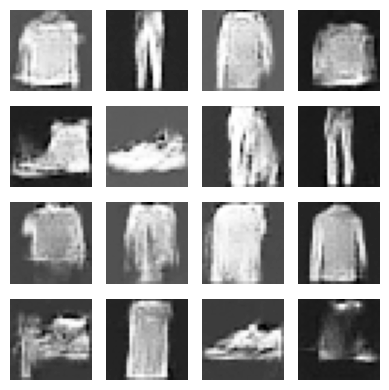

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Critic Loss: -0.5414, Generator Loss: 0.0987 Epoch Time: 48.43s


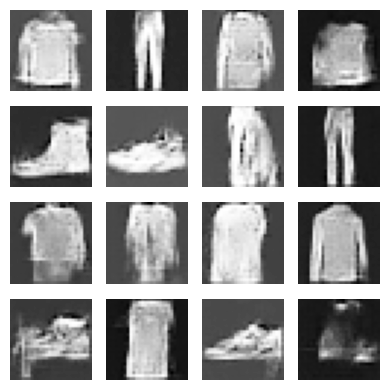

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Critic Loss: -0.5341, Generator Loss: 0.0920 Epoch Time: 48.22s


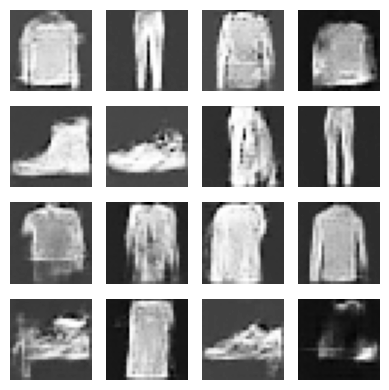

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Critic Loss: -0.5097, Generator Loss: 0.0841 Epoch Time: 48.35s


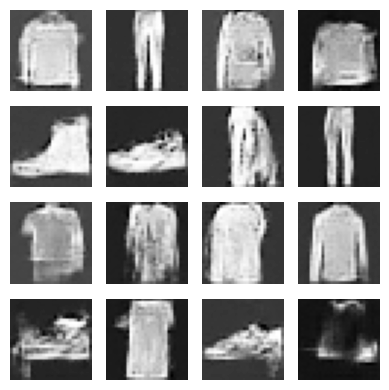

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Critic Loss: -0.4872, Generator Loss: 0.0779 Epoch Time: 48.42s


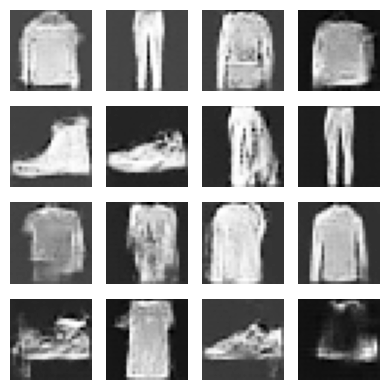

In [70]:
generator_losses_weights_init, critic_losses_weights_init = train_wgan(generator, 
           critic, 
           dataloader, 
           optimizer_generator, 
           optimizer_discriminator, 
           num_epochs=10, 
           clip_value=0.01, 
           n_critic=6, 
           device=device)

В целом, мы видим добротное качество генерации (визуально)

Далее изменим логику для задания №2

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

Напишем обновлённую формулу для gradient penalty и потери критика

$\mathcal{L}_D = \mathbb{E}_{\widetilde{x} \sim p_{g}}  [D(\widetilde{x})] - \mathbb{E}_{x \sim p_{r}} [D(x)] + \lambda \mathbb{E}_{\hat{x} \sim p_{\hat{x}}} [(|| \nabla_{\hat{x}} D (\hat{x})) ||_{2} - 1)^{2}]$

In [45]:
def gradient_penalty(gradient):
    '''Вычисление компоненты матожидания для penalty в формуле'''
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

def get_crit_loss_gradient_penalty(crit_fake_pred, 
                                   crit_real_pred, 
                                   gradient_penalty, 
                                   lambda_coef):
    '''
    Функция потерь для критика (с учётом gradient_penalty)
    
    Параметры:
    -crit_fake_pred: предсказания критика на fake-данных
    -crit_real_pred: предсказания критика на real-данных
    -gradient_penalty: компонент из штрафа градиента
    -lambda_coef: лямбда-коэффициент (из формулы)
    
    Возвращает потери критика
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + lambda_coef * gradient_penalty
    return crit_loss

def calc_gradient(critic, real_data, fake_data, epsilon):
    
    '''
    Функция подсчета градиента по примеру из статьи

    Параметры:
    -critic: критик
    -real_data: input критика
    -fake_data: input генератора
    -epsilon: коэффициент эпсилон
    '''

    # Логика из формулы
    x_hat = real_data * epsilon + fake_data * (1 - epsilon)
    outputs = critic(x_hat)

    # Подсчёет градиента
    gradient = torch.autograd.grad(
        inputs=x_hat,
        outputs=outputs,
        grad_outputs=torch.ones_like(outputs), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

Теперь нужно обновить логику для train-loop

<img src="pictures/loss_gradient_penalty.png" alt="Gradient Penalty algorithm" width="700" height="400">

In [64]:
def train_wgan_gradient_penalty(generator, 
            critic, 
            train_loader, 
            optimizer_generator, 
            optimizer_discriminator, 
            num_epochs=10, 
            lambda_coef = 10,
            n_critic=5, 
            device = 'cpu'):
    '''
    Функция обучения для WGAN с использованием gradient_penalty
    
    Параметры:
    
    -generator: генератор (модель генератора)
    -critic: критик (дискриминатор)
    -train_loader: тренировочный dataloader
    -optimizer_generator: оптимизатор для генератора
    -optimizer_discriminator: оптимизатор для критика
    -num_epochs: количество эпох для обучения
    -lambda_coef: коэффициент лямбда (default: 10, как указано в статье)
    -clip_value: значение для ограничения весов (weight clipping)
    -n_critic: количество шагов для критика перед шагом генератора
    -device: устройство
    '''
    
    generator.train()
    critic.train()

    fixed_noise = torch.randn(16, 100, device=device) 
    
    critic_losses = []  # Потери критика
    generator_losses = []  # Потери генератора

    for epoch in tqdm(range(num_epochs)):
        
        start_time = time.time()
        critic_loss_total = 0
        generator_loss_total = 0
        for i, (real_data, _) in enumerate(tqdm(train_loader)):
            
            real_data = real_data.to(device)
            # генерация шума размерности 100
            noise = torch.randn(real_data.size(0), 100, device=device)  
            # n_critic шагов для критика
            for _ in range(n_critic):
                optimizer_discriminator.zero_grad()
                # Генерация фейковых данных
                fake_data = generator(noise)
                real_output = critic(real_data)
                fake_output = critic(fake_data.detach())

                epsilon = torch.rand(len(real_data), 1, 1, 1, device=device, requires_grad=True)
                gradient = calc_gradient(critic, real_data, fake_data.detach(), epsilon)
                gradient_penalty_component = gradient_penalty(gradient)
                
                # Loss
                critic_loss = get_crit_loss_gradient_penalty(fake_output, real_output, 
                                                             gradient_penalty_component, 
                                                             lambda_coef)
                # Backward
                critic_loss.backward()
                optimizer_discriminator.step()
                critic_loss_total += ( critic_loss.item() / n_critic )
                    
            # Очередь генератора
            optimizer_generator.zero_grad()
            # Генерация fake-данных
            fake_data = generator(noise)
            # Output критика на fake-данных
            fake_output = critic(fake_data)
            # Loss
            generator_loss = get_gen_loss(fake_output)
            # Обновляем веса генератора
            generator_loss.backward()
            optimizer_generator.step()
            generator_loss_total += generator_loss.item()
        
        critic_losses.append(critic_loss_total / len(train_loader))
        generator_losses.append(generator_loss_total / len(train_loader))

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Critic Loss: {critic_loss_total/len(train_loader):.4f}, "
            f"Generator Loss: {generator_loss_total/len(train_loader):.4f}",
            f"Epoch Time: {epoch_time:.2f}s")

        fake = fixed_noise
        generate_and_plot(generator, fixed_noise, epoch)
    
    return generator_losses, critic_losses



Объявляем оптимизаторы и модели

In [66]:
generator_gradient_penalty = GeneratorConv().to(device).apply(weights_init)
critic_gradient_penalty = Critic().to(device).apply(weights_init)

# Оптимизатор берется с параметрами, указанными в статье
optimizer_generator_gradient_penalty = optim.Adam(generator_gradient_penalty.parameters(), lr=0.0001, betas=(0.5, 0.9))  
optimizer_discriminator_gradient_penalty = optim.Adam(critic_gradient_penalty.parameters(), lr=0.0001, betas=(0.5, 0.9))    

Пробуем обучать

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Critic Loss: -19.1817, Generator Loss: -20.6032 Epoch Time: 79.87s


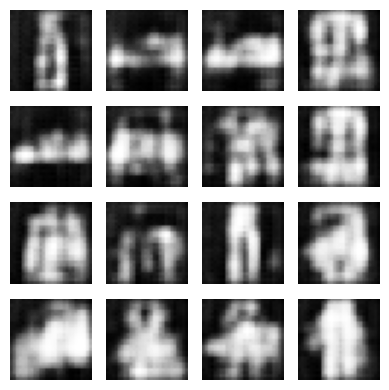

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Critic Loss: -11.0601, Generator Loss: -39.9167 Epoch Time: 80.11s


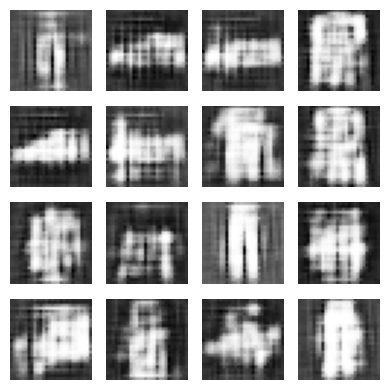

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Critic Loss: -42.1340, Generator Loss: -10.7433 Epoch Time: 79.71s


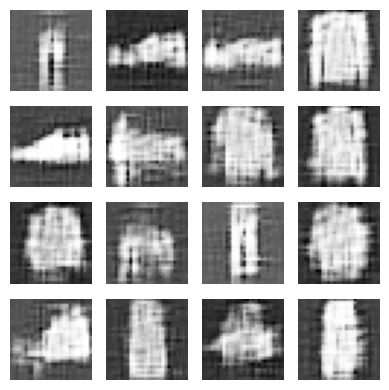

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Critic Loss: -116.8359, Generator Loss: 43.0989 Epoch Time: 79.59s


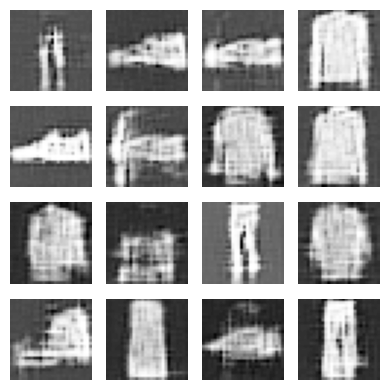

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Critic Loss: -208.1064, Generator Loss: 108.0232 Epoch Time: 79.72s


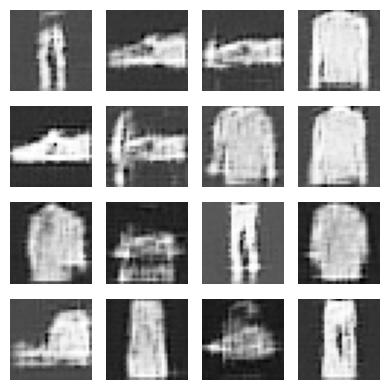

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Critic Loss: -283.6384, Generator Loss: 183.1770 Epoch Time: 79.88s


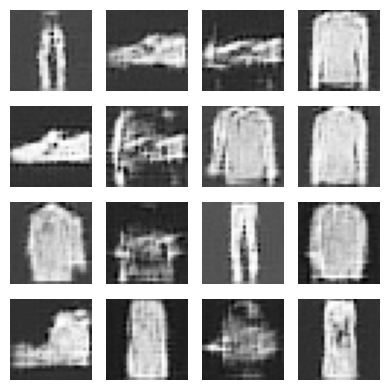

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Critic Loss: -339.8917, Generator Loss: 234.0166 Epoch Time: 80.35s


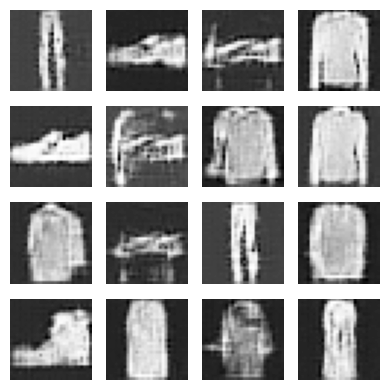

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Critic Loss: -362.2427, Generator Loss: 274.5830 Epoch Time: 79.70s


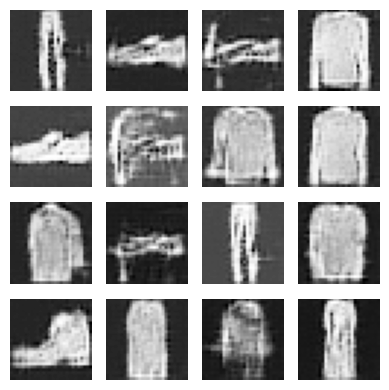

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Critic Loss: -437.2744, Generator Loss: 315.5376 Epoch Time: 79.73s


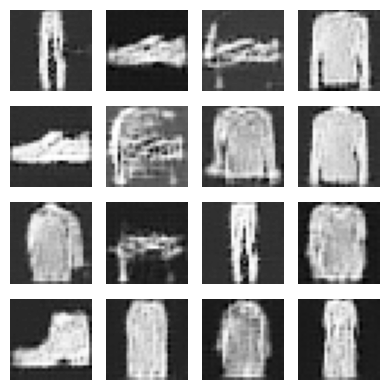

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Critic Loss: -499.8054, Generator Loss: 369.6303 Epoch Time: 80.03s


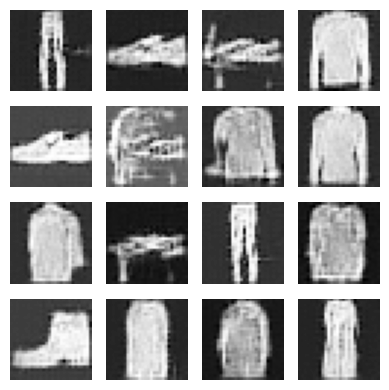

In [67]:
generator_losses_gradient_penalty, critic_losses_gradient_penalty = train_wgan_gradient_penalty(generator_gradient_penalty, 
           critic_gradient_penalty, 
           dataloader, 
           optimizer_generator_gradient_penalty, 
           optimizer_discriminator_gradient_penalty, 
           num_epochs=10, 
           n_critic=5, 
           device=device)

Итак, GAN чему-то обучился

Далее перейдем к заданию №3

Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл)


Перестроим критик и генератор

In [ ]:
class GeneratorConvConditional(nn.Module):
    '''Класс модели условного генератора, который генерирует изображения через операцию ConvTranspose2D()'''
    
    def __init__(self, noise_dim=100, im_chan=1, hidden_dim=64, n_labels=10):
        super(GeneratorConvConditional, self).__init__()

        self.labels_embedding = nn.Embedding(n_labels, n_labels) # Через слой Эмбеддинга будем учитывать метку класса
        self.n_labels = n_labels
        self.noise_dim = 100
        
        # Сеть генератора
        self.from_noise_to_images = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + n_labels, hidden_dim * 4, kernel_size=3, stride=2, padding=0), # Concat
            nn.BatchNorm2d(hidden_dim * 4), 
            nn.ReLU(inplace=True), 

            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1, padding=0), 
            nn.BatchNorm2d(hidden_dim * 2), 
            nn.ReLU(inplace=True), 

            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=0),  
            nn.BatchNorm2d(hidden_dim),  
            nn.ReLU(inplace=True),  

            nn.ConvTranspose2d(hidden_dim, im_chan, kernel_size=4, stride=2, padding=0),  
            nn.Tanh()  
        )
    
    # forward call
    def forward(self, x, labels):
        label_embeddings = self.labels_embedding(labels) # Метка -> эмбеддинг
        combined_input = torch.cat((x, label_embeddings), dim=1) # Concat
        combined_input = combined_input.view(len(combined_input), self.noise_dim + self.n_labels, 1, 1) # Concat as input
        return self.from_noise_to_images(combined_input)


Пример работы

In [119]:
generator = GeneratorConvConditional(noise_dim=100, im_chan=1, hidden_dim=64, n_labels=10)

batch_size = 16
noise = torch.randn(batch_size, 100)  
labels = torch.randint(0, 10, (batch_size,))  

fake_images = generator(noise, labels)
print(fake_images.shape) 

torch.Size([16, 1, 28, 28])


Далее перейдем к критику

In [120]:
class CriticConditional(nn.Module):
    '''Класс модели критика (дискриминатора) которая учитывает Embedding метки,
    здесь мы по сути учитываем информацию о метке и создаем дополнительные каналы,
    характеризующие конкретную метку'''

    def __init__(self, in_channels=1, n_labels = 10, image_size=28):
        super(CriticConditional, self).__init__()

        self.n_labels = n_labels
        self.label_embedding = nn.Embedding(n_labels, n_labels)
        self.image_size = image_size
        
        # Сеть дискриминатора
        self.model_discriminator = nn.Sequential(
            nn.Conv2d(in_channels + n_labels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(256 * (image_size // 8) * (image_size // 8), 1),
        )

    # forward call
    def forward(self, x, labels):
        # print(x.size())
        # print(labels.size())
        label_embedding = self.label_embedding(labels)  
        # print(label_embedding.size())
        label_map = label_embedding.view(len(label_embedding), self.n_labels, 1, 1)
        # print(label_map.size())
        label_map = label_map.expand(-1, self.n_labels, self.image_size, self.image_size)
        # print(label_map.size())
        x = torch.cat([x, label_map], dim=1)  
        return self.model_discriminator(x)


Пример работы

In [121]:
critic = CriticConditional(in_channels=1, n_labels=10, image_size=28)
x = torch.randn(16, 1, 28, 28)
labels = torch.randint(0, 10, (16,))

output = critic(x, labels)
print(output.shape)  

torch.Size([16, 1])


Теперь нужно обновить функцию train-loop

In [ ]:
def train_wgan_conditional(generator, 
            critic, 
            train_loader, 
            optimizer_generator, 
            optimizer_discriminator, 
            num_epochs=10, 
            clip_value=0.01, 
            n_critic=5, 
            device = 'cpu'):
    '''
    Функция обучения для WGAN
    
    Параметры:
    
    -generator: генератор (модель генератора)
    -critic: критик (дискриминатор)
    -train_loader: тренировочный dataloader
    -optimizer_generator: оптимизатор для генератора
    -optimizer_discriminator: оптимизатор для критика
    -num_epochs: количество эпох для обучения
    -clip_value: значение для ограничения весов (weight clipping)
    -n_critic: количество шагов для критика перед шагом генератора
    -device: устройство
    '''
    
    generator.train()
    critic.train()

    # Необходимо для генерации после каждой эпохи
    fixed_noise = torch.randn(10, 100, device=device)  
    label_one_hot = torch.eye(10, device=device).long() # OHE для предсказаний каждого класс

    critic_losses = []  # Потери критика
    generator_losses = []  # Потери генератора

    for epoch in tqdm(range(num_epochs)):
        
        start_time = time.time()
        critic_loss_total = 0
        generator_loss_total = 0
        for i, (real_data, labels) in enumerate(tqdm(train_loader)):
            
            real_data = real_data.to(device)
            labels = labels.to(device)
            # генерация шума размерности 100
            noise = torch.randn(real_data.size(0), 100, device=device)  
            # n_critic шагов для критика
            for _ in range(n_critic):
                optimizer_discriminator.zero_grad()
                # Генерация фейковых данных
                fake_data = generator(noise, labels)
                
                real_output = critic(real_data, labels)
                fake_output = critic(fake_data.detach(), labels)
                # Loss
                critic_loss = get_crit_loss(fake_output, real_output)
                # Backward
                critic_loss.backward()
                optimizer_discriminator.step()
                # Применяем weight clipping
                for param in critic.parameters():
                    param.data.clamp_(-clip_value, clip_value)
                
                critic_loss_total += critic_loss.item() / n_critic

            # Очередь генератора
            optimizer_generator.zero_grad()
            # Генерация fake-данных
            fake_data = generator(noise, labels)
            # Output критика на fake-данных
            fake_output = critic(fake_data, labels)
            # Loss
            generator_loss = get_gen_loss(fake_output)
            # Обновляем веса генератора
            generator_loss.backward()
            optimizer_generator.step()
            generator_loss_total += generator_loss.item()
        
        critic_losses.append(critic_loss_total / len(train_loader))
        generator_losses.append(generator_loss_total / len(train_loader))

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Critic Loss: {critic_loss_total/len(train_loader):.4f}, "
            f"Generator Loss: {generator_loss_total/len(train_loader):.4f}",
            f"Epoch Time: {epoch_time:.2f}s")

        '''Проверка условной генерации'''
        fake_images_for_labels = []
        for label in range(10): 
            print(fixed_noise[label].size())
            print(label_one_hot[label].size())
            print(fixed_noise[label].unsqueeze(0).size())
            print(label_one_hot[label].unsqueeze(0).size())
            fake_data = generator(fixed_noise[label].unsqueeze(0), label_one_hot[label].unsqueeze(0))
            fake_images_for_labels.append(fake_data)

        fig, axes = plt.subplots(2, 5, figsize=(6, 6))
        axes = axes.flatten()

        for i, ax in enumerate(axes):
            ax.imshow(fake_images_for_labels[i].detach().cpu().squeeze().numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f"{i}: {label_names[i]}", fontsize=10)

        plt.tight_layout()
        plt.show()
    
    return generator_losses, critic_losses



Инициализируем оптимизаторы и модели

In [128]:
device = 'cuda'

generator_conditional = GeneratorConvConditional().to(device)
critic_conditional = CriticConditional().to(device)

generator_conditional = generator_conditional.apply(weights_init)
critic_conditional = critic_conditional.apply(weights_init)

optimizer_generator_conditional = optim.RMSprop(generator_conditional.parameters(), lr=0.0001)  
optimizer_discriminator_conditional = optim.RMSprop(critic_conditional.parameters(), lr=0.0001)    


Пробуем обучать

In [ ]:
generator_losses_conditional, critic_losses_conditional = train_wgan_conditional(generator_conditional, 
           critic_conditional, 
           dataloader, 
           optimizer_generator_conditional, 
           optimizer_discriminator_conditional, 
           num_epochs=10, 
           n_critic=5, 
           device='cuda')

Гифка

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import imageio
import matplotlib.animation as animation

folder_path = 'generated_images'

image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

image_extensions = ['.png']
image_files = [f for f in image_files if any(f.lower().endswith(ext) for ext in image_extensions)]

image_files.sort()

images = []
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    images.append(imageio.imread(image_path))

output_path = 'wgan.gif'
imageio.mimsave(output_path, images, duration=10)  